# Convolutional Neural Network Notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flictionary'

In [3]:
from glob import glob
import ast
import cv2
import time
import ast
from tqdm import tqdm
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
import glob
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet

BASE_SIZE = 256
DP_DIR = os.path.join(base_dir, "animals/shuffle_csv/")
INPUT_DIR = os.path.join(base_dir, "animals/")
# DP_DIR = "../animals/shuffle_csv/"
# INPUT_DIR = '../animals/'
NCSVS = 100
NCATS = 47

size = 80

In [4]:
startTime = time.time()

In [5]:

classes_path = os.listdir(INPUT_DIR + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
# dictionary for 
class_dict = {x[:-4]:i for i, x in enumerate(classes_path)}
labels = {x[:-4] for i, x in enumerate(classes_path)}

n_labels = len(labels)
print("Number of labels: {}".format(n_labels))  

n_files = n_labels 

Number of labels: 47


In [6]:
class_dict

{'ant': 0,
 'bat': 1,
 'bear': 2,
 'bee': 3,
 'butterfly': 4,
 'camel': 5,
 'cat': 6,
 'cow': 7,
 'crab': 8,
 'crocodile': 9,
 'dog': 10,
 'dolphin': 11,
 'dragon': 12,
 'duck': 13,
 'elephant': 14,
 'flamingo': 15,
 'frog': 16,
 'giraffe': 17,
 'hedgehog': 18,
 'horse': 19,
 'kangaroo': 20,
 'lion': 21,
 'lobster': 22,
 'monkey': 23,
 'mosquito': 24,
 'mouse': 25,
 'octopus': 26,
 'owl': 27,
 'panda': 28,
 'parrot': 29,
 'penguin': 30,
 'pig': 31,
 'rabbit': 32,
 'raccoon': 33,
 'rhinoceros': 34,
 'scorpion': 35,
 'sea turtle': 36,
 'shark': 37,
 'sheep': 38,
 'snail': 39,
 'snake': 40,
 'spider': 41,
 'squirrel': 42,
 'swan': 43,
 'tiger': 44,
 'whale': 45,
 'zebra': 46}

In [8]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator(size, batchsize, ks, lw=6):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
                x = x / 255.
                x = x.reshape((len(df), size, size, 1)).astype(np.float32)
                y = tf.keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x


In [9]:
path = '/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/'
all_files = glob.glob(path + "/*.csv")
nb_files=len(all_files)
nb_mots=47
n_sample_perfile=5000
test_size_val=0.2

In [10]:
li = []
count=0

for filename in all_files[0:nb_mots]:
    print(filename)
    df_reduced = pd.read_csv(filename, index_col=None, header=0, nrows=50000)
    df_reduced = df_reduced[df_reduced['recognized']==True].sample(n=n_sample_perfile, random_state=42)
    
    count+=1
    print(df_reduced.size,count ,'/',nb_files)
    li.append(df_reduced)

print('load done for',nb_mots,'files')
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.sample(n=n_sample_perfile*nb_mots, random_state=24)

del li

/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/ant.csv
30000 1 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bat.csv
30000 2 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bear.csv
30000 3 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bee.csv
30000 4 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/butterfly.csv
30000 5 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/camel.csv
30000 6 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/cat.csv
30000 7 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/cow.csv
30000 8 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/crab.csv
30000 9 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/crocodile.csv
30000 10 / 47
/content/driv

In [11]:
frame['target'] = frame.word.apply(lambda x: class_dict[x])
frame.head()

,countrycode,drawing,key_id,recognized,timestamp,word,target
214466,BR,"[[[30, 42, 64, 75, 96, 131, 161, 166, 172, 171...",6638315052728320,True,2017-01-27 02:53:16.590100,squirrel,42
28942,US,"[[[0, 7, 30, 38, 63, 80, 102, 107, 134, 166, 1...",5564305795710976,True,2017-03-09 07:38:24.237540,camel,5
68850,KR,"[[[125, 116, 106, 46, 7, 1, 0, 28, 109, 121], ...",6376936676786176,True,2017-03-19 07:44:49.346800,duck,13
212489,US,"[[[202, 202, 190, 192, 189, 182, 169, 163, 188...",4870239898566656,True,2017-01-12 22:29:45.089930,squirrel,42
192971,RU,"[[[54, 41, 22, 16, 49, 51, 73, 134, 157, 161, ...",6574981330763776,True,2017-01-23 18:21:32.543370,sheep,38


In [12]:
frame.to_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/frame2.csv', index=False)
frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/frame2.csv')

In [30]:
frame.head()

,countrycode,drawing,key_id,recognized,timestamp,word,target
0,HU,"[[[127, 120, 106, 77, 46, 20, 2, 1, 6, 15, 30,...",5537863812775936,True,2017-03-19 21:03:56.941010,tiger,44
1,RU,"[[[47, 32, 19, 6, 0, 4, 5, 21, 44, 55], [48, 4...",5553311824478208,True,2017-01-28 14:10:04.744630,parrot,29
2,PH,"[[[104, 112, 127, 159, 198, 211, 217, 247, 253...",6148243845021696,True,2017-03-05 10:20:02.143980,duck,13
3,NO,"[[[223, 174, 169, 163, 163, 174, 185, 229, 243...",5664324594958336,True,2017-03-26 12:41:17.163870,ant,0
4,AE,"[[[121, 96, 48, 35, 10, 5, 6], [66, 62, 84, 86...",6340930657320960,True,2017-03-29 13:38:59.322040,dog,10


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(frame.drop(['countrycode', 'word', 'key_id', 'target', 'recognized', 'timestamp'], axis=1), 
                                                      frame['target'], 
                                                      test_size = test_size_val, 
                                                      random_state = 42)

In [16]:
STEPS = 1000
batchsize = 512
epochs = 20

In [17]:
X_tr = df_to_image_array(X_train, size)
y_tr = tf.keras.utils.to_categorical(y_train, num_classes=NCATS)
print(X_tr.shape, y_tr.shape)

(188000, 80, 80, 1) (188000, 47)


In [20]:
X_val = df_to_image_array(X_valid, size)
y_val = tf.keras.utils.to_categorical(y_valid, num_classes=NCATS)
print(X_val.shape, y_val.shape)

(47000, 80, 80, 1) (47000, 47)


In [19]:
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_tr.pickle', 'wb') as f:
    pickle.dump(X_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_tr.pickle', 'wb') as f:
    pickle.dump(y_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_val.pickle', 'wb') as f:
    pickle.dump(X_val, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_val.pickle', 'wb') as f:
    pickle.dump(y_val, f, pickle.HIGHEST_PROTOCOL)

In [22]:
base_model = MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=n_labels)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_labels, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy]
              )

In [24]:
lr_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                 factor=0.5, 
                                 patience=5,
                                 min_delta=0.005, 
                                 mode='max', 
                                 cooldown=3, 
                                 verbose=1)
filepath = '/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/model.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_categorical_crossentropy', 
                           mode = 'min')
log_dir = "/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/log.csv')


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 40, 40, 32)        0     

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_2/model.{epoch:02d}-{val_loss:.2f}.hdf5')

In [26]:
history = model.fit(X_tr, y_tr, 
                    steps_per_epoch=STEPS, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger]
)

Epoch 1/20
1000/1000 [==============================] - 135s 116ms/step - loss: 3.3715 - categorical_crossentropy: 3.3715 - categorical_accuracy: 0.1066 - top_3_accuracy: 0.2505 - val_loss: 3.1579 - val_categorical_crossentropy: 3.1579 - val_categorical_accuracy: 0.1503 - val_top_3_accuracy: 0.3271

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/model.01-3.16.hdf5
Epoch 2/20
1000/1000 [==============================] - 113s 113ms/step - loss: 2.9014 - categorical_crossentropy: 2.9014 - categorical_accuracy: 0.2113 - top_3_accuracy: 0.4157 - val_loss: 2.6896 - val_categorical_crossentropy: 2.6896 - val_categorical_accuracy: 0.2649 - val_top_3_accuracy: 0.4858

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/model.02-2.69.hdf5
Epoch 3/20
1000/1000 [==============================] - 112s 112ms/step - loss: 2.2795 - categorical_crossentropy: 2.2795 - categorical_accuracy: 0.3614 - top_3_accuracy:

In [29]:
history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/log.csv')

In [31]:
history

,epoch,categorical_accuracy,categorical_crossentropy,loss,lr,top_3_accuracy,val_categorical_accuracy,val_categorical_crossentropy,val_loss,val_top_3_accuracy
0,0,0.106612,3.371483,3.371483,0.00010,0.250463,0.150319,3.157868,3.157868,0.327064
1,1,0.211277,2.901415,2.901415,0.00010,0.415670,0.264851,2.689561,2.689561,0.485809
2,2,0.361372,2.279467,2.279467,0.00010,0.602388,0.407723,2.103235,2.103235,0.651979
3,3,0.490984,1.771199,1.771199,0.00010,0.728718,0.511106,1.705211,1.705211,0.747021
4,4,0.577394,1.449005,1.449005,0.00010,0.798048,0.562319,1.516599,1.516599,0.786851
5,5,0.638080,1.222278,1.222278,0.00010,0.842330,0.590043,1.406302,1.406302,0.809255
6,6,0.687043,1.041620,1.041620,0.00010,0.875963,0.602383,1.375642,1.375642,0.815277
7,7,0.731160,0.888806,0.888806,0.00010,0.902154,0.607532,1.374438,1.374438,0.820149
8,8,0.770484,0.747081,0.747081,0.00010,0.924947,0.613766,1.391002,1.391002,0.823808
9,9,0.807649,0.618578,0.618578,0.00010,0.944239,0.614638,1.447780,1.447780,0.819787


In [43]:
def train_val_metrics(epochs, model_training):
    epochs = range(1, epochs+1)
    metrics = model_training
    train_loss = metrics['categorical_crossentropy']
    train_acc = metrics['categorical_accuracy']
    train_acc_2 = metrics['top_3_accuracy']
    val_loss = metrics['val_categorical_crossentropy']
    val_acc = metrics['val_categorical_accuracy']
    val_acc_2 = metrics['val_top_3_accuracy']
    
    
    ax = plt.subplot(311)
    train, = ax.plot(epochs, train_loss)
    val, = ax.plot(epochs, val_loss)
    ax.legend([train, val], ['training', 'validation'])
    ax.set(xlabel='epochs', ylabel='categorical\n cross-entropy loss')

    ax2 = plt.subplot(312)
    train2, = ax2.plot(epochs, train_acc)
    val2, = ax2.plot(epochs, val_acc)
    ax2.legend([train2, val2], ['training', 'validation'])
    ax2.set(xlabel='epochs', ylabel='categorical\n accuracy')

    ax3 = plt.subplot(313)
    train3, = ax3.plot(epochs, train_acc_2)
    val3, = ax3.plot(epochs, val_acc_2)
    ax3.legend([train3, val3], ['training', 'validation'])
    ax3.set(xlabel='epochs', ylabel='top 3\n accuracy')

    plt.tight_layout(h_pad=5, w_pad=5)
    plt.gcf().set_size_inches(12, 6)


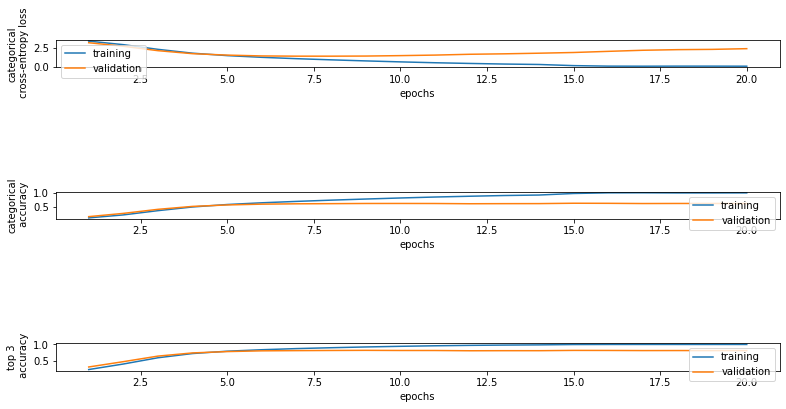

In [44]:
train_val_metrics(20, history)

In [45]:
plt.style.use('seaborn')
def generate_graph(history, title):
    plt.plot(history['categorical_accuracy'])
    plt.plot(history['val_categorical_accuracy'])
    plt.plot(history['top_3_accuracy'])
    plt.plot(history['val_top_3_accuracy'])
    plt.title('Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation', 'test top 3', 'validation top 3'], loc='upper left')
    plt.show()
    plt.plot(history['categorical_crossentropy'])
    plt.plot(history['val_categorical_crossentropy'])
    plt.title('Loss ' + title)
    plt.ylabel('MLogLoss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

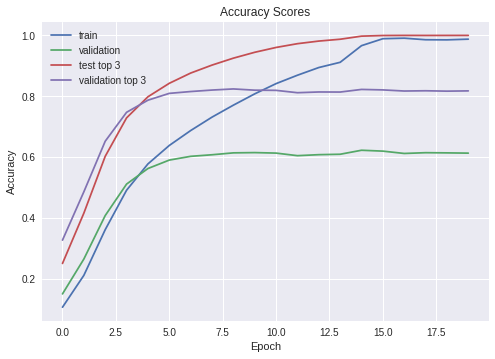

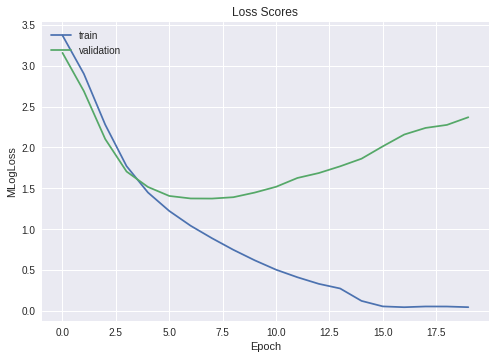

In [46]:
#plot
generate_graph(history, "Scores")

In [47]:
endTime = time.time()
print(endTime - startTime)

3108.745754003525
